<a href="https://colab.research.google.com/github/stiwari-ds/DL-Simplified-SWOC-S3/blob/phishing-website-detection/Phishing-Website-Detection/Model/02_sklearn_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [**Multi-Layer Perceptron classifier using Scikit-learn**](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

# Setup

In [43]:
#Utils
import gc
import os
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

#Data analysis
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'

#Reproducibility
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [44]:
#modeling
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Data

**Cleaned data and feature sets (from [EDA notebook](https://github.com/stiwari-ds/DL-Simplified-SWOC-S3/blob/phishing-website-detection/Phishing-Website-Detection/Model/00_eda_and_preprocessing.ipynb))**

In [45]:
#data: cleaned version
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/DL-Simplified-SWOC-S3/phishing-website-detection/Phishing-Website-Detection/Dataset/processed/phishing_website_dataset_cleaned.csv'
data = pd.read_csv(DATA_URL)

In [46]:
TARGET = 'result'

all_features = [f for f in data.columns if f != TARGET]

reduced_features = [
    f for f in all_features if f not in 
    ('favicon', 'submitting_to_email', 'redirect', 'right_click',
    'popup_window', 'iframe', 'links_pointing_to_page')
]

top_features = [
    'ssl_final_state', 'url_of_anchor', 'prefix_suffix', 
    'web_traffic', 'having_subdomain', 'links_in_tags', 
    'request_url', 'sfh', 'domain_registration_length'
]

# Modeling

In [47]:
def evaluate(model, feature_set, seed, return_oof=False):
    cv_rocauc = []
    cv_acc = []
    oof_preds = {}

    X, y = data[feature_set], data[TARGET]
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        val_probs = model.predict_proba(X_val)[:, 1]
        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_idx, val_preds)))
        
        cv_rocauc.append(roc_auc_score(y_val, val_probs))
        cv_acc.append(accuracy_score(y_val, val_preds))
    
    avg_acc = np.mean(cv_acc)
    avg_rocauc = np.mean(cv_rocauc)
    oof_preds = pd.Series(oof_preds).sort_index()
    
    if return_oof: 
        return avg_rocauc, avg_acc, oof_preds
    else: 
        return avg_rocauc, avg_acc

In [48]:
def run_experiment(model, feature_set, verbose=False, runs=10):
    training_seeds = np.random.randint(low=1, high=1e5, size=runs)
    
    all_rocauc = []
    all_acc = []
    for i, seed in enumerate(training_seeds):
        rocauc, acc = evaluate(model, feature_set, seed)
        all_rocauc.append(rocauc)
        all_acc.append(acc)
        if verbose:
            print(f'Run #{i+1:<2} [seed = {seed:<4}]: ' \
                  f'ROC-AUC = {rocauc:.4f}, Accuracy = {acc:.4f}')
        
    print(f'\nAverage over {runs} runs of 10-fold CV: ' \
          f'ROC-AUC = {np.mean(all_rocauc):.4f}+/-{np.std(all_rocauc):.4f}, ' \
          f'Accuracy = {np.mean(all_acc):.4f}+/-{np.std(all_acc):.4f}\n')

In [49]:
base_params = {
    'max_iter': 1000,
    'shuffle': True,
    'tol': 2e-4,
    'early_stopping': True,
    'n_iter_no_change': 10
}

## Shallow neural network

In [50]:
%%time
model1 = MLPClassifier(**base_params) #default: 1 hidden layer, size = 100
run_experiment(model1, top_features, verbose=True, runs=3)

Run #1  [seed = 4127]: ROC-AUC = 0.9851, Accuracy = 0.9356
Run #2  [seed = 74863]: ROC-AUC = 0.9847, Accuracy = 0.9355
Run #3  [seed = 13464]: ROC-AUC = 0.9802, Accuracy = 0.9286

Average over 3 runs of 10-fold CV: ROC-AUC = 0.9834+/-0.0022, Accuracy = 0.9332+/-0.0033

CPU times: user 1min 38s, sys: 1min 22s, total: 3min
Wall time: 1min 44s


In [51]:
%%time
run_experiment(model1, top_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9833+/-0.0012, Accuracy = 0.9328+/-0.0020

CPU times: user 4min 40s, sys: 3min 43s, total: 8min 23s
Wall time: 4min 22s


In [52]:
%%time
run_experiment(model1, reduced_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9901+/-0.0007, Accuracy = 0.9487+/-0.0015

CPU times: user 7min 32s, sys: 5min 32s, total: 13min 5s
Wall time: 6min 46s


In [53]:
%%time
run_experiment(model1, all_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9926+/-0.0011, Accuracy = 0.9559+/-0.0025

CPU times: user 8min 37s, sys: 6min 11s, total: 14min 48s
Wall time: 7min 39s


**We have already surpassed our [target baseline score](https://colab.research.google.com/drive/1rlOr88p4nHO0si1t_TuBjOnGreFGpDPH#scrollTo=0J3FUDeoPBK9) with a shallow neural network.**  
Next, we will work with multiple hidden layers to create deep neural networks.

## Deep neural network

In [54]:
model2 = MLPClassifier(
    **base_params,
    hidden_layer_sizes=(64, 64)
)

In [55]:
%%time
run_experiment(model2, top_features, verbose=True, runs=3)

Run #1  [seed = 54692]: ROC-AUC = 0.9871, Accuracy = 0.9403
Run #2  [seed = 21352]: ROC-AUC = 0.9867, Accuracy = 0.9396
Run #3  [seed = 84863]: ROC-AUC = 0.9865, Accuracy = 0.9383

Average over 3 runs of 10-fold CV: ROC-AUC = 0.9868+/-0.0002, Accuracy = 0.9394+/-0.0008

CPU times: user 1min 54s, sys: 1min 24s, total: 3min 18s
Wall time: 1min 43s


In [56]:
%%time
run_experiment(model2, top_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9868+/-0.0004, Accuracy = 0.9382+/-0.0011

CPU times: user 6min 18s, sys: 4min 26s, total: 10min 45s
Wall time: 5min 37s


In [57]:
%%time
run_experiment(model2, reduced_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9926+/-0.0005, Accuracy = 0.9557+/-0.0016

CPU times: user 8min 51s, sys: 5min 58s, total: 14min 49s
Wall time: 7min 40s


In [58]:
%%time
run_experiment(model2, all_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9942+/-0.0003, Accuracy = 0.9622+/-0.0014

CPU times: user 10min 17s, sys: 6min 50s, total: 17min 8s
Wall time: 8min 52s


**Easily beating the target baseline and also outperforming the shallow neural network.**  
Next, we can tune the hyperparameters to squeeze out some more performance. We will use all the features to do so, since we are aiming for best performance in terms of accuracy/AUC.

## Hyperparameter tuning

In [59]:
param_grid = {
    'hidden_layer_sizes': [(128, 128), (128, 64), (64, 64, 64), (32, 32, 32)],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 1.0],
    'batch_size': [64, 128, 256, 512],
    'learning_rate_init': [0.001, 0.01, 0.1, 1.0]
}

In [60]:
%%time
mlp_tuner = HalvingGridSearchCV(
    estimator=MLPClassifier(**base_params),
    param_grid=param_grid,
    factor=2,
    cv=10,
    scoring='accuracy',
    refit=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=2
)

mlp_tuner.fit(data[all_features], data[TARGET])

n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 9
min_resources_: 43
max_resources_: 11055
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 384
n_resources: 43
Fitting 10 folds for each of 384 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 192
n_resources: 86
Fitting 10 folds for each of 192 candidates, totalling 1920 fits
----------
iter: 2
n_candidates: 96
n_resources: 172
Fitting 10 folds for each of 96 candidates, totalling 960 fits
----------
iter: 3
n_candidates: 48
n_resources: 344
Fitting 10 folds for each of 48 candidates, totalling 480 fits
----------
iter: 4
n_candidates: 24
n_resources: 688
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 5
n_candidates: 12
n_resources: 1376
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 6
n_candidates: 6
n_resources: 2752
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 7
n_candidates: 3
n_r

HalvingGridSearchCV(cv=10,
                    estimator=MLPClassifier(early_stopping=True, max_iter=1000,
                                            tol=0.0002),
                    factor=2, n_jobs=-1,
                    param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 1.0],
                                'batch_size': [64, 128, 256, 512],
                                'hidden_layer_sizes': [(128, 128), (128, 64),
                                                       (64, 64, 64),
                                                       (32, 32, 32)],
                                'learning_rate_init': [0.001, 0.01, 0.1, 1.0]},
                    random_state=2311, scoring='accuracy', verbose=2)

In [61]:
mlp_tuner.best_params_

{'alpha': 0.001,
 'batch_size': 256,
 'hidden_layer_sizes': (128, 128),
 'learning_rate_init': 0.01}

In [62]:
mlp_tuner.best_score_

0.9662842044422426

# Results analysis

### 1. Base MLP

In [63]:
simple_mlp = MLPClassifier(**base_params, hidden_layer_sizes=(64, 64))

simple_rocauc, simple_acc, simple_oof = evaluate(simple_mlp, all_features, seed=SEED, return_oof=True)

In [64]:
print(f'ROC-AUC = {simple_rocauc:.4f}, Accuracy = {simple_acc:.4f}')

ROC-AUC = 0.9944, Accuracy = 0.9627


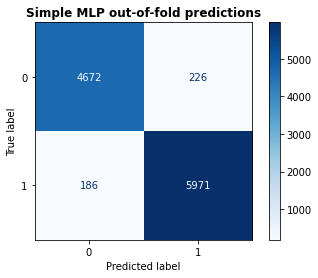

In [65]:
simple_cm = ConfusionMatrixDisplay.from_predictions(data[TARGET], simple_oof, cmap='Blues')
simple_cm.ax_.set_title('Simple MLP out-of-fold predictions',
                    fontweight='bold', fontsize=12, ha='center')
plt.savefig(fname='simple-mlp-confusion-matrix.png', bbox_inches='tight')
plt.show()

### 2. Best MLP after hyperparameter-tuning

In [66]:
best_mlp = MLPClassifier(**base_params, **mlp_tuner.best_params_)

best_rocauc, best_acc, best_oof = evaluate(best_mlp, all_features, seed=SEED, return_oof=True)

In [67]:
print(f'ROC-AUC = {best_rocauc:.4f}, Accuracy = {best_acc:.4f}')

ROC-AUC = 0.9956, Accuracy = 0.9673


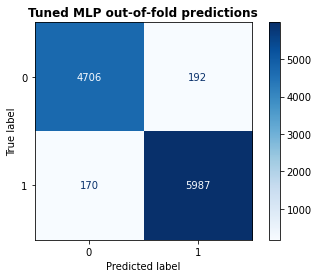

In [68]:
best_cm = ConfusionMatrixDisplay.from_predictions(data[TARGET], best_oof, cmap='Blues')
best_cm.ax_.set_title('Tuned MLP out-of-fold predictions',
                    fontweight='bold', fontsize=12, ha='center')
plt.savefig(fname='tuned-mlp-confusion-matrix.png', bbox_inches='tight')
plt.show()

**We can see significant reduction in both false-negatives and false-positives compared to the ML models in [notebook 01](https://github.com/stiwari-ds/DL-Simplified-SWOC-S3/blob/phishing-website-detection/Phishing-Website-Detection/Model/01_ml_baseline.ipynb), which shows that the tuned deep neural network is able to learn an overall better representation of our data.**